## Width vs Depth [Part 1].ipynb

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os

import pickle
import copy
import os

In [2]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

def get_relu_joint(weight_1, weight_2, bias, extent=1):
    if np.abs(weight_2) < 1e-8: 
        x_intercept = -bias / weight_1
        return [[x_intercept, -extent], [x_intercept, extent]] if -extent <= x_intercept <= extent else []
    elif np.abs(weight_1) < 1e-8:
        y_intercept = -bias / weight_2
        return [[-extent, y_intercept], [extent, y_intercept]] if -extent <= y_intercept <= extent else []
    else:
        points = []
        for x in [-extent, extent]:
            y = (-x * weight_1 - bias) / weight_2
            if -extent <= y <= extent: points.append([x, y])
        for y in [-extent, extent]:
            x = (-y * weight_2 - bias) / weight_1
            if -extent <= x <= extent: points.append([x, y])
        unique_points = []
        for p in points:
            is_duplicate = False
            for existing in unique_points:
                if abs(p[0] - existing[0]) < 1e-8 and abs(p[1] - existing[1]) < 1e-8:
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_points.append(p)
        return unique_points

def viz_map_with_predictions(ax, map, X, y):
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    
    X_denorm=denorm(X[:1000,:])
    # plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)
    labels=y[:1000]
    y_hat=torch.argmax(model(torch.tensor(X[:1000,:]).float()).detach(),1).numpy()
    tp_mask=np.logical_and(labels==1, y_hat==1)
    fp_mask=np.logical_and(labels==0, y_hat==1)
    fn_mask=np.logical_and(labels==1, y_hat==0)
    tn_mask=np.logical_and(labels==0, y_hat==0)
    ax.scatter(X_denorm[tp_mask,0], X_denorm[tp_mask,1], c='g', s=3, alpha=0.8)
    ax.scatter(X_denorm[fp_mask,0], X_denorm[fp_mask,1], c='r', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[fn_mask,0], X_denorm[fn_mask,1], c='orange', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[tn_mask,0], X_denorm[tn_mask,1], c='purple', marker='o', s=5, alpha=0.8)

def save_viz(model, save_path=None):
    plt.clf()
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    
    fig=plt.figure(0,(10,10)); 
    ax=fig.add_subplot(111)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(np.argmin(probe_logits, 2)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    # ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
    #            extent=[0, 960, 960, 0],  # This maps to image coordinates
    #            alpha=0.7,
    #            cmap='viridis')
    if save_path is not None: plt.savefig(save_path)

def extract_weights_to_numpy(model, layer_indices=None, output_file=None):
    """
    Extract PyTorch model weights and biases to NumPy arrays with copy-paste ready code.
    
    Args:
        model: PyTorch model
        layer_indices: List of layer indices to extract (if None, extracts all layers with weights)
        output_file: Optional file path to save the output code
    
    Returns:
        String containing the NumPy array definitions ready to copy-paste
    """
    
    lines = []
    lines.append("import numpy as np\n")
    
    # Auto-detect layers if not specified
    if layer_indices is None:
        layer_indices = []
        for i, layer in enumerate(model.model):
            if hasattr(layer, 'weight'):
                layer_indices.append(i)
    
    # Extract weights and biases
    weight_counter = 1
    for idx in layer_indices:
        layer = model.model[idx]
        
        if hasattr(layer, 'weight'):
            # Extract weight
            weight_np = layer.weight.detach().numpy()
            weight_repr = np.array2string(weight_np, 
                                        separator=', ', 
                                        formatter={'float_kind': lambda x: f"{x:g}"})
            lines.append(f"w{weight_counter} = np.array({weight_repr}, dtype=np.float32)")
            
            # Extract bias if it exists
            if hasattr(layer, 'bias') and layer.bias is not None:
                bias_np = layer.bias.detach().numpy()
                bias_repr = np.array2string(bias_np, 
                                          separator=', ', 
                                          formatter={'float_kind': lambda x: f"{x:g}"})
                lines.append(f"b{weight_counter} = np.array({bias_repr}, dtype=np.float32)")
            
            weight_counter += 1
    
    output = '\n'.join(lines)
    
    # Save to file if specified
    if output_file:
        with open(output_file, 'w') as f:
            f.write(output)
        print(f"Weights saved to {output_file}")
    
    # Print to console
    print(output)
    return output

In [3]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en.svg.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<10
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

In [4]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

## [2]

In [14]:
# accuracies=[]
# for random_seed in range(32):
#     torch.manual_seed(random_seed)
#     X_tensor = torch.FloatTensor(X)
#     y_tensor = torch.tensor(y)
    
#     # Initialize model and optimizer
#     model = BaarleNet([2])
    
#     #Larger weight init
#     # bound=2.5
#     # with torch.no_grad():
#     #     model.model[0].weight.uniform_(-bound, bound)
#     #     model.model[0].bias.uniform_(-bound, bound)  
#     #     model.model[2].weight.uniform_(-bound, bound)
#     #     model.model[2].bias.uniform_(-bound, bound)  
#     #     if len(model.model)>3: #ONLY SETUP FOR 2 hidden layers so far!
#     #         model.model[4].weight.uniform_(-bound, bound)
#     #         model.model[4].bias.uniform_(-bound, bound) 

#     criterion = nn.CrossEntropyLoss()
#     # optimizer = optim.SGD(model.parameters(), lr=0.25)
#     optimizer = optim.Adam(model.parameters(), lr=0.0025) #0.005
    
#     num_epochs = 12000
#     for epoch in range(num_epochs):
#         # Batch
#         # outputs = model(X_tensor)
#         # loss = criterion(outputs, y_tensor)
    
#         #Stochastic
#         outputs = model(torch.tensor(X[epoch%len(y)]).float())
#         loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()

#         optimizer.step()
        
#     outputs_batch = model(X_tensor)
#     accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
#     print(f'Random Seed [{random_seed}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
#     accuracies.append(accuracy)

Random Seed [0], Loss: 0.4571, Accuracy: 0.7136
Random Seed [1], Loss: 0.5292, Accuracy: 0.6516
Random Seed [2], Loss: 0.8653, Accuracy: 0.7587
Random Seed [3], Loss: 0.5291, Accuracy: 0.6520
Random Seed [4], Loss: 0.5246, Accuracy: 0.6540
Random Seed [5], Loss: 0.5565, Accuracy: 0.6228
Random Seed [6], Loss: 0.5622, Accuracy: 0.6293
Random Seed [7], Loss: 0.7054, Accuracy: 0.5000
Random Seed [8], Loss: 1.2201, Accuracy: 0.7598
Random Seed [9], Loss: 1.0874, Accuracy: 0.7711
Random Seed [10], Loss: 0.5293, Accuracy: 0.6530
Random Seed [11], Loss: 1.3919, Accuracy: 0.7518
Random Seed [12], Loss: 0.6923, Accuracy: 0.6260
Random Seed [13], Loss: 0.5610, Accuracy: 0.6299
Random Seed [14], Loss: 0.7899, Accuracy: 0.7527
Random Seed [15], Loss: 0.9275, Accuracy: 0.7667
Random Seed [16], Loss: 0.9444, Accuracy: 0.7726
Random Seed [17], Loss: 0.5611, Accuracy: 0.6299
Random Seed [18], Loss: 1.1112, Accuracy: 0.7763
Random Seed [19], Loss: 0.7054, Accuracy: 0.5000
Random Seed [20], Loss: 0.9583

In [19]:
random_seed=25
torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([2])
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005
# optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005

num_epochs = 12000
for epoch in range(num_epochs):
    # Batch
    # outputs = model(X_tensor)
    # loss = criterion(outputs, y_tensor)

    #Stochastic
    outputs = model(torch.tensor(X[epoch%len(y)]).float())
    loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

    #Worth trying minibatch?
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//10) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [1200/12000], Loss: 0.2917, Accuracy: 0.7723
Epoch [2400/12000], Loss: 0.2362, Accuracy: 0.7613
Epoch [3600/12000], Loss: 0.4775, Accuracy: 0.7735
Epoch [4800/12000], Loss: 1.7065, Accuracy: 0.7791
Epoch [6000/12000], Loss: 1.7396, Accuracy: 0.7754
Epoch [7200/12000], Loss: 1.1143, Accuracy: 0.7873
Epoch [8400/12000], Loss: 0.0784, Accuracy: 0.7869
Epoch [9600/12000], Loss: 0.2220, Accuracy: 0.7792
Epoch [10800/12000], Loss: 0.5440, Accuracy: 0.7835
Epoch [12000/12000], Loss: 0.4371, Accuracy: 0.7887


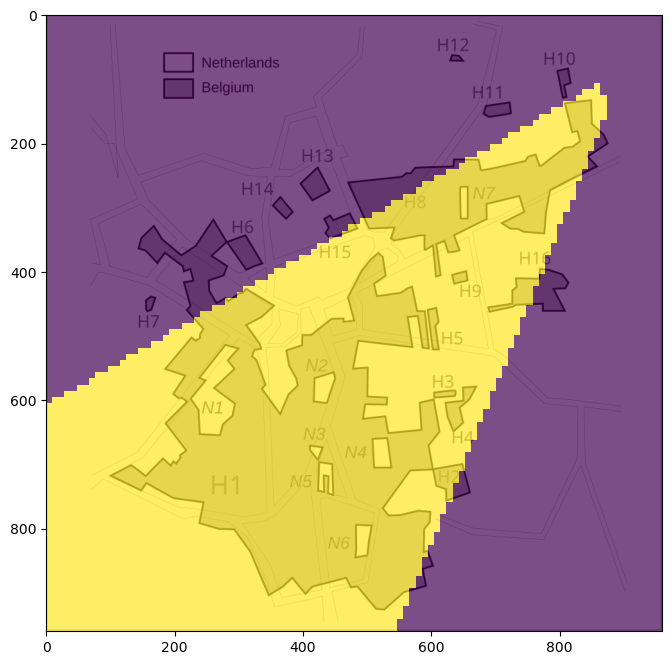

In [20]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)

probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)
probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

ax.imshow(map.mean(2), cmap='gray')
ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')

In [21]:
torch.save(model.state_dict(), '../models/2_1.pth')

In [22]:
_=extract_weights_to_numpy(model)

import numpy as np

w1 = np.array([[2.5135, -1.02481],
 [-1.4043, 2.41291]], dtype=np.float32)
b1 = np.array([-1.23981, -0.450078], dtype=np.float32)
w2 = np.array([[3.17024, 1.32567],
 [-3.40372, -1.53878]], dtype=np.float32)
b2 = np.array([-0.884835, 0.0332228], dtype=np.float32)


## 2x2

In [5]:
# accuracies=[]
# for random_seed in range(20):
#     torch.manual_seed(random_seed)
#     X_tensor = torch.FloatTensor(X)
#     y_tensor = torch.tensor(y)
    
#     # Initialize model and optimizer
#     model = BaarleNet([2,2])
    
#     #Larger weight init
#     bound=2.5
#     with torch.no_grad():
#         model.model[0].weight.uniform_(-bound, bound)
#         model.model[0].bias.uniform_(-bound, bound)  
#         model.model[2].weight.uniform_(-bound, bound)
#         model.model[2].bias.uniform_(-bound, bound)  
#         if len(model.model)>3: #ONLY SETUP FOR 2 hidden layers so far!
#             model.model[4].weight.uniform_(-bound, bound)
#             model.model[4].bias.uniform_(-bound, bound) 

#     criterion = nn.CrossEntropyLoss()
#     # optimizer = optim.SGD(model.parameters(), lr=0.25)
#     optimizer = optim.Adam(model.parameters(), lr=0.0025) #0.005
    
#     num_epochs = 12000
#     for epoch in range(num_epochs):
#         # Batch
#         # outputs = model(X_tensor)
#         # loss = criterion(outputs, y_tensor)
    
#         #Stochastic
#         outputs = model(torch.tensor(X[epoch%len(y)]).float())
#         loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()

#         optimizer.step()
        
#     outputs_batch = model(X_tensor)
#     accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
#     print(f'Random Seed [{random_seed}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
#     accuracies.append(accuracy)

- Ok wow 2x2 model seems kind a lottery ticket-y
- So the narrative angle then might be comparing like a 32 or 64 neuron shallow model to distributing those neurons?
- I think I can collapse down to somethign small to make points as I need to?
- Yeah so it takes a long time to find a lottery ticket, and the decision boundary is not that cool once you do.
- Yeah what's like the minimum interesting depth example?
- Like "oh my god, if you take these N neurons from a single layer and spread them accross J layers you can do whatever the fuck you want." 

In [10]:
random_seed=315
torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([2,2])
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.002) #0.005
# optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005

num_epochs = 60000
for epoch in range(num_epochs):
    # Batch
    # outputs = model(X_tensor)
    # loss = criterion(outputs, y_tensor)

    #Stochastic
    outputs = model(torch.tensor(X[epoch%len(y)]).float())
    loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

    #Worth trying minibatch?
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//10) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [6000/60000], Loss: 1.0814, Accuracy: 0.8238
Epoch [12000/60000], Loss: 0.1560, Accuracy: 0.8322
Epoch [18000/60000], Loss: 0.5560, Accuracy: 0.8330
Epoch [24000/60000], Loss: 0.1302, Accuracy: 0.8437
Epoch [30000/60000], Loss: 0.7305, Accuracy: 0.8556
Epoch [36000/60000], Loss: 0.6927, Accuracy: 0.8395
Epoch [42000/60000], Loss: 0.0494, Accuracy: 0.8427
Epoch [48000/60000], Loss: 0.2830, Accuracy: 0.8519
Epoch [54000/60000], Loss: 0.2597, Accuracy: 0.8572
Epoch [60000/60000], Loss: 0.1252, Accuracy: 0.8488


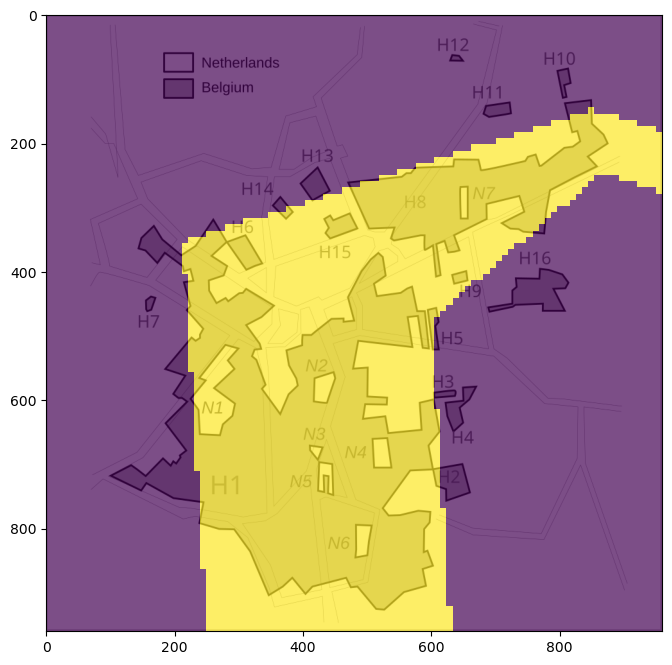

In [11]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)

probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)
probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

ax.imshow(map.mean(2), cmap='gray')
ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')

In [12]:
_=extract_weights_to_numpy(model)

import numpy as np

w1 = np.array([[0.51659, 1.6567],
 [-1.3146, -0.0829751]], dtype=np.float32)
b1 = np.array([-0.149871, 1.10656], dtype=np.float32)
w2 = np.array([[1.19949, 0.941819],
 [-0.913628, -1.27943]], dtype=np.float32)
b2 = np.array([-1.44471, 1.31709], dtype=np.float32)
w3 = np.array([[3.76982, 3.47801],
 [-3.60214, -2.64052]], dtype=np.float32)
b3 = np.array([-1.21362, 0.801899], dtype=np.float32)


In [14]:
# torch.save(model.state_dict(), '../models/2_2_1.pth')

## 3x3

In [8]:
# accuracies=[]
# for random_seed in range(32):
#     torch.manual_seed(random_seed)
#     X_tensor = torch.FloatTensor(X)
#     y_tensor = torch.tensor(y)
    
#     # Initialize model and optimizer
#     model = BaarleNet([3,3])
    
#     #Larger weight init
#     # bound=2.5
#     # with torch.no_grad():
#     #     model.model[0].weight.uniform_(-bound, bound)
#     #     model.model[0].bias.uniform_(-bound, bound)  
#     #     model.model[2].weight.uniform_(-bound, bound)
#     #     model.model[2].bias.uniform_(-bound, bound)  
#     #     if len(model.model)>3: #ONLY SETUP FOR 2 hidden layers so far!
#     #         model.model[4].weight.uniform_(-bound, bound)
#     #         model.model[4].bias.uniform_(-bound, bound) 

#     criterion = nn.CrossEntropyLoss()
#     # optimizer = optim.SGD(model.parameters(), lr=0.25)
#     optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005
    
#     num_epochs = 4000
#     for epoch in range(num_epochs):
#         # Batch
#         outputs = model(X_tensor)
#         loss = criterion(outputs, y_tensor)
    
#         # #Stochastic
#         # outputs = model(torch.tensor(X[epoch%len(y)]).float())
#         # loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()

#         optimizer.step()
        
#     outputs_batch = model(X_tensor)
#     accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
#     print(f'Random Seed [{random_seed}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
#     accuracies.append(accuracy)

Random Seed [0], Loss: 0.4766, Accuracy: 0.7616
Random Seed [1], Loss: 0.3531, Accuracy: 0.8544
Random Seed [2], Loss: 0.4498, Accuracy: 0.7934
Random Seed [3], Loss: 0.3248, Accuracy: 0.8645
Random Seed [4], Loss: 0.3286, Accuracy: 0.8671
Random Seed [5], Loss: 0.4512, Accuracy: 0.7907
Random Seed [6], Loss: 0.3314, Accuracy: 0.8679
Random Seed [7], Loss: 0.3823, Accuracy: 0.8356
Random Seed [8], Loss: 0.4584, Accuracy: 0.7876
Random Seed [9], Loss: 0.3511, Accuracy: 0.8569
Random Seed [10], Loss: 0.3130, Accuracy: 0.8758
Random Seed [11], Loss: 0.3199, Accuracy: 0.8710
Random Seed [12], Loss: 0.3828, Accuracy: 0.8419
Random Seed [13], Loss: 0.3390, Accuracy: 0.8654
Random Seed [14], Loss: 0.4071, Accuracy: 0.8161
Random Seed [15], Loss: 0.2950, Accuracy: 0.8757
Random Seed [16], Loss: 0.3340, Accuracy: 0.8579
Random Seed [17], Loss: 0.4498, Accuracy: 0.7932
Random Seed [18], Loss: 0.3328, Accuracy: 0.8571
Random Seed [19], Loss: 0.4766, Accuracy: 0.7612
Random Seed [20], Loss: 0.3439

In [10]:
random_seed=11
torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([3,3])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005) #0.005


num_epochs = 12000
for epoch in range(num_epochs):
    # Batch
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    #Stochastic
    # outputs = model(torch.tensor(X[epoch%len(y)]).float())
    # loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

    #Worth trying minibatch?
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//10) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [1200/12000], Loss: 0.3306, Accuracy: 0.8655
Epoch [2400/12000], Loss: 0.3248, Accuracy: 0.8690
Epoch [3600/12000], Loss: 0.3211, Accuracy: 0.8702
Epoch [4800/12000], Loss: 0.3186, Accuracy: 0.8709
Epoch [6000/12000], Loss: 0.3172, Accuracy: 0.8721
Epoch [7200/12000], Loss: 0.3163, Accuracy: 0.8722
Epoch [8400/12000], Loss: 0.3148, Accuracy: 0.8739
Epoch [9600/12000], Loss: 0.3139, Accuracy: 0.8743
Epoch [10800/12000], Loss: 0.3134, Accuracy: 0.8749
Epoch [12000/12000], Loss: 0.3132, Accuracy: 0.8751


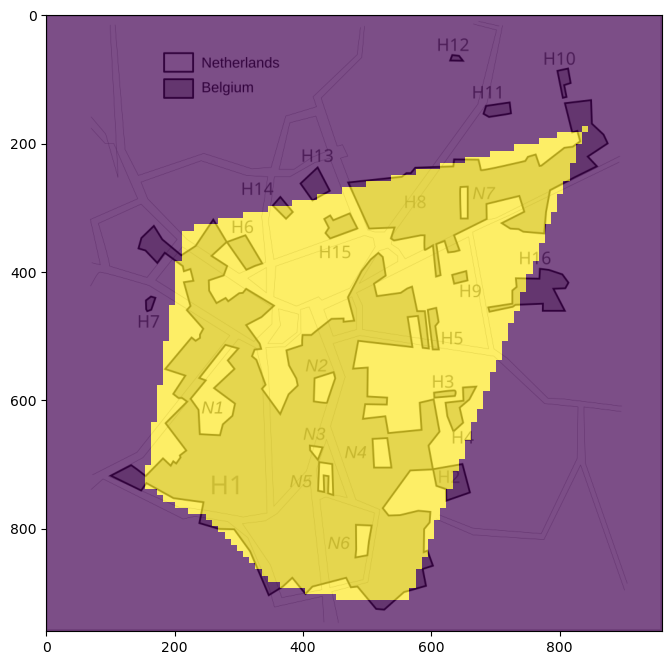

In [11]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)

probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)
probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

ax.imshow(map.mean(2), cmap='gray')
ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')

In [12]:
# torch.save(model.state_dict(), '../models/3_3_1.pth')

## 4x4

In [11]:
accuracies=[]
for random_seed in range(32):
    torch.manual_seed(random_seed)
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Initialize model and optimizer
    model = BaarleNet([4,4])

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.25)
    optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005
    
    num_epochs = 4000
    for epoch in range(num_epochs):
        # Batch
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
    
        # #Stochastic
        # outputs = model(torch.tensor(X[epoch%len(y)]).float())
        # loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        
    outputs_batch = model(X_tensor)
    accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
    print(f'Random Seed [{random_seed}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    accuracies.append(accuracy)

Random Seed [0], Loss: 0.3381, Accuracy: 0.8623
Random Seed [1], Loss: 0.3446, Accuracy: 0.8539
Random Seed [2], Loss: 0.3252, Accuracy: 0.8662
Random Seed [3], Loss: 0.3073, Accuracy: 0.8790
Random Seed [4], Loss: 0.3284, Accuracy: 0.8542
Random Seed [5], Loss: 0.3117, Accuracy: 0.8770
Random Seed [6], Loss: 0.2957, Accuracy: 0.8788
Random Seed [7], Loss: 0.2657, Accuracy: 0.8824
Random Seed [8], Loss: 0.3514, Accuracy: 0.8519
Random Seed [9], Loss: 0.3304, Accuracy: 0.8649
Random Seed [10], Loss: 0.3072, Accuracy: 0.8699
Random Seed [11], Loss: 0.3445, Accuracy: 0.8582
Random Seed [12], Loss: 0.3390, Accuracy: 0.8560
Random Seed [13], Loss: 0.3268, Accuracy: 0.8785
Random Seed [14], Loss: 0.2627, Accuracy: 0.8901
Random Seed [15], Loss: 0.3579, Accuracy: 0.8573
Random Seed [16], Loss: 0.4601, Accuracy: 0.7867
Random Seed [17], Loss: 0.3595, Accuracy: 0.8525
Random Seed [18], Loss: 0.3668, Accuracy: 0.8540
Random Seed [19], Loss: 0.2984, Accuracy: 0.8776
Random Seed [20], Loss: 0.3262

In [ ]:
random_seed=11
torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([4,4])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005) #0.005


num_epochs = 12000
for epoch in range(num_epochs):
    # Batch
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    #Stochastic
    # outputs = model(torch.tensor(X[epoch%len(y)]).float())
    # loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

    #Worth trying minibatch?
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//10) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


In [ ]:
# fig=plt.figure(0,(8,8))
# ax=fig.add_subplot(111)

# probe=np.zeros((100,100,2))
# for j, xx in enumerate(np.linspace(-1, 1, 100)):
#     for k, yy in enumerate(np.linspace(-1, 1, 100)):
#         probe[j, k]=[yy,xx]
# probe=probe.reshape(100**2, -1)
# probe_logits=model(torch.tensor(probe).float())
# probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
# probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

# ax.imshow(map.mean(2), cmap='gray')
# ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
#            extent=[0, 960, 960, 0],  # This maps to image coordinates
#            alpha=0.7,
#            cmap='viridis')

In [ ]:
# torch.save(model.state_dict(), '../models/4_4_1.pth')

In [9]:
_=extract_weights_to_numpy(model)

import numpy as np

w1 = np.array([[0.517837, 1.75789],
 [-1.27265, -0.087746]], dtype=np.float32)
b1 = np.array([-0.127576, 1.05139], dtype=np.float32)
w2 = np.array([[1.20559, 0.960618],
 [-0.819331, -1.2194]], dtype=np.float32)
b2 = np.array([-1.40305, 1.17917], dtype=np.float32)
w3 = np.array([[3.48773, 3.53277],
 [-3.32003, -2.6953]], dtype=np.float32)
b3 = np.array([-1.18046, 0.768749], dtype=np.float32)


## 2x2x2

In [5]:
accuracies=[]
for random_seed in range(32):
    torch.manual_seed(random_seed)
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Initialize model and optimizer
    model = BaarleNet([2,2,2])
    
    #Larger weight init
    # bound=2.5
    # with torch.no_grad():
    #     model.model[0].weight.uniform_(-bound, bound)
    #     model.model[0].bias.uniform_(-bound, bound)  
    #     model.model[2].weight.uniform_(-bound, bound)
    #     model.model[2].bias.uniform_(-bound, bound)  
    #     if len(model.model)>3: #ONLY SETUP FOR 2 hidden layers so far!
    #         model.model[4].weight.uniform_(-bound, bound)
    #         model.model[4].bias.uniform_(-bound, bound) 

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.25)
    optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005
    
    num_epochs = 4000
    for epoch in range(num_epochs):
        # Batch
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
    
        # #Stochastic
        # outputs = model(torch.tensor(X[epoch%len(y)]).float())
        # loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        
    outputs_batch = model(X_tensor)
    accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
    print(f'Random Seed [{random_seed}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    accuracies.append(accuracy)

Random Seed [0], Loss: 0.6931, Accuracy: 0.5000
Random Seed [1], Loss: 0.5910, Accuracy: 0.6578
Random Seed [2], Loss: 0.5394, Accuracy: 0.7232
Random Seed [3], Loss: 0.6931, Accuracy: 0.5000
Random Seed [4], Loss: 0.6931, Accuracy: 0.5000
Random Seed [5], Loss: 0.5332, Accuracy: 0.7266
Random Seed [6], Loss: 0.5956, Accuracy: 0.6351
Random Seed [7], Loss: 0.5957, Accuracy: 0.6347
Random Seed [8], Loss: 0.4525, Accuracy: 0.7884
Random Seed [9], Loss: 0.6931, Accuracy: 0.5000
Random Seed [10], Loss: 0.6004, Accuracy: 0.6537
Random Seed [11], Loss: 0.4209, Accuracy: 0.8286
Random Seed [12], Loss: 0.6931, Accuracy: 0.5000
Random Seed [13], Loss: 0.6931, Accuracy: 0.5000
Random Seed [14], Loss: 0.4551, Accuracy: 0.7891
Random Seed [15], Loss: 0.6163, Accuracy: 0.6232
Random Seed [16], Loss: 0.6931, Accuracy: 0.5000
Random Seed [17], Loss: 0.6931, Accuracy: 0.5000
Random Seed [18], Loss: 0.6931, Accuracy: 0.5000
Random Seed [19], Loss: 0.6931, Accuracy: 0.5000
Random Seed [20], Loss: 0.6931

In [8]:
random_seed=30
torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([2,2,2])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005) #0.005


num_epochs = 12000
for epoch in range(num_epochs):
    # Batch
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    #Stochastic
    # outputs = model(torch.tensor(X[epoch%len(y)]).float())
    # loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

    #Worth trying minibatch?
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//10) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [1200/12000], Loss: 0.5368, Accuracy: 0.7470
Epoch [2400/12000], Loss: 0.4912, Accuracy: 0.7875
Epoch [3600/12000], Loss: 0.4912, Accuracy: 0.7875
Epoch [4800/12000], Loss: 0.4913, Accuracy: 0.7875
Epoch [6000/12000], Loss: 0.4913, Accuracy: 0.7874
Epoch [7200/12000], Loss: 0.4912, Accuracy: 0.7876
Epoch [8400/12000], Loss: 0.4912, Accuracy: 0.7875
Epoch [9600/12000], Loss: 0.4913, Accuracy: 0.7877
Epoch [10800/12000], Loss: 0.4913, Accuracy: 0.7875
Epoch [12000/12000], Loss: 0.4913, Accuracy: 0.7875


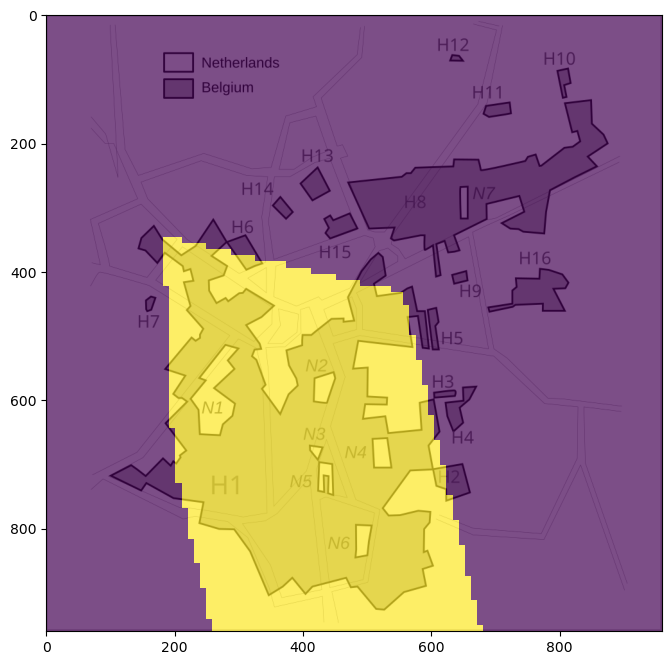

In [9]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)

probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)
probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

ax.imshow(map.mean(2), cmap='gray')
ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')

In [10]:
torch.save(model.state_dict(), '../models/2_2_2_1.pth')